# ResNet50 Model 

#### With only 2 emotions

In [2]:
# Core Dependencies (for all models)
import os
import numpy as np
import matplotlib.pyplot as plt

# Deep Learning Dependencies
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, load_model

# Custom Dependencies (for ResNet50)
from tensorflow.keras.applications import ResNet50, ResNet50V2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten

In [3]:
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices: 
    print("GPU is available") 
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
else:
    print("GPU is not available") 

GPU is not available


### Load and Pre-process FER2013 Dataset

In [4]:
# Define the Paths 
dataset_train = 'FER2013/train'
dataset_test = 'FER2013/test'

# Define the Image Size and Parameters
img_size = (48, 48)
input_shape = (48, 48, 3)
batch_size = 64

## Trial #3: ResNet50 with Pretrained Weights

### Create Data Generators 

In [5]:
# Data Preprocessing and augmentation 
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.15,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Train Generator 
train_generator = train_datagen.flow_from_directory(
    dataset_train,
    target_size=img_size,
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

# Validation Generator
val_generator = train_datagen.flow_from_directory(
    dataset_train,
    target_size=img_size,
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)

# Test Generator
test_generator = test_datagen.flow_from_directory(
    dataset_test,
    target_size=img_size,
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 10239 images belonging to 2 classes.
Found 1806 images belonging to 2 classes.
Found 3021 images belonging to 2 classes.


### Load ResNet50 Base with ImageNet Weights

In [6]:
# Add class weights 
num_classes = len(train_generator.class_indices)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights_dict = dict(enumerate(class_weights))

In [7]:
# Define ResNet50V2 model (pretrained w/ Imagenet Weights)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze base model (for now)
for layer in base_model.layers:
    layer.trainable = False

### Define the ResNet Model

In [8]:
# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(num_classes, activation='softmax')(x)

# Create the model
model_3 = Model(inputs=base_model.input, outputs=output)

In [9]:
# Create a loss function that is appropriate for multi-class classification
loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=False)

# Compile the ResNet Model 
model_3.compile(optimizer=Adam(learning_rate=1e-3),
              loss=loss_fn,
              metrics=['accuracy'])

initial_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=6, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(patience=3, factor=0.5)
]

### Train the Model

#### Phase 1: Inital Training

In [10]:
# Start the initial training
history = model_3.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    callbacks=initial_callbacks,
    class_weight=class_weights_dict
)

Epoch 1/30


/opt/anaconda3/envs/env1/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


160/160 ━━━━━━━━━━━━━━━━━━━━ 19s 109ms/step - accuracy: 0.5090 - loss: 0.7893 - val_accuracy: 0.4009 - val_loss: 0.7052 - learning_rate: 0.0010
Epoch 2/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 17s 106ms/step - accuracy: 0.5085 - loss: 0.6959 - val_accuracy: 0.5980 - val_loss: 0.6874 - learning_rate: 0.0010
Epoch 3/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 18s 111ms/step - accuracy: 0.4537 - loss: 0.6934 - val_accuracy: 0.4009 - val_loss: 0.6932 - learning_rate: 0.0010
Epoch 4/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 18s 111ms/step - accuracy: 0.4966 - loss: 0.6943 - val_accuracy: 0.6019 - val_loss: 0.6918 - learning_rate: 0.0010
Epoch 5/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 18s 109ms/step - accuracy: 0.5841 - loss: 0.6922 - val_accuracy: 0.4009 - val_loss: 0.6940 - learning_rate: 0.0010
Epoch 6/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 18s 111ms/step - accuracy: 0.5004 - loss: 0.6928 - val_accuracy: 0.3992 - val_loss: 0.6939 - learning_rate: 5.0000e-04
Epoch 7/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 18s 115ms/step - accuracy: 0.4341 - l

#### Phase 2: Final Training (unfreeze and fine-tune)

In [11]:
# Fine-tune the model (unfreeze the last 50% of ResNet50 layers)
for layer in base_model.layers[-50:]:
    layer.trainable = True


# Compile (adding a lower learning rate)
model_3.compile(optimizer=Adam(learning_rate=1e-5),
              loss=loss_fn,
              metrics=['accuracy'])

fine_tune_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=7, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(patience=3, factor=0.5)
]

# Continue training (fine-tune entire model)
history_finetune = model_3.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    callbacks=fine_tune_callbacks,
    class_weight=class_weights_dict
)

Epoch 1/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 63s 372ms/step - accuracy: 0.5160 - loss: 0.7546 - val_accuracy: 0.5365 - val_loss: 0.6925 - learning_rate: 1.0000e-05
Epoch 2/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 59s 366ms/step - accuracy: 0.5100 - loss: 0.7311 - val_accuracy: 0.5437 - val_loss: 0.6885 - learning_rate: 1.0000e-05
Epoch 3/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 59s 369ms/step - accuracy: 0.5126 - loss: 0.7196 - val_accuracy: 0.5066 - val_loss: 0.6984 - learning_rate: 1.0000e-05
Epoch 4/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 60s 372ms/step - accuracy: 0.5323 - loss: 0.7042 - val_accuracy: 0.5759 - val_loss: 0.6784 - learning_rate: 1.0000e-05
Epoch 5/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 59s 370ms/step - accuracy: 0.5383 - loss: 0.6991 - val_accuracy: 0.4718 - val_loss: 0.7111 - learning_rate: 1.0000e-05
Epoch 6/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 61s 383ms/step - accuracy: 0.5364 - loss: 0.7000 - val_accuracy: 0.4856 - val_loss: 0.6968 - learning_rate: 1.0000e-05
Epoch 7/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 62s 38

In [12]:
# # Save the weights
# model_3.save_weights('ResNet50_weights.weights.h5')

### Evaluate

In [13]:
test_loss, test_accuracy = model_3.evaluate(test_generator)
print(f"Final Test Accuracy: {test_accuracy:.4f}")
print(f"Final Test Loss: {test_loss:.4f}")

48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step - accuracy: 0.7626 - loss: 0.5474
Final Test Accuracy: 0.6531
Final Test Loss: 0.6236


### Plot Training History 

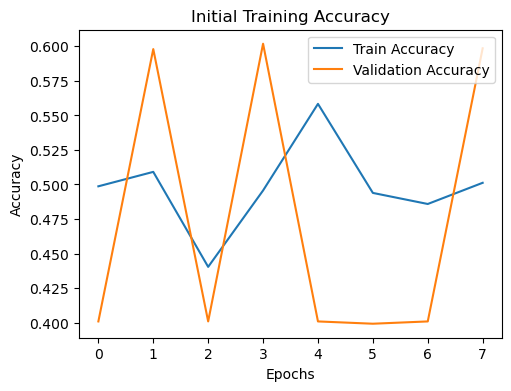

In [14]:
# Plotting the model accuracy 
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Initial Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

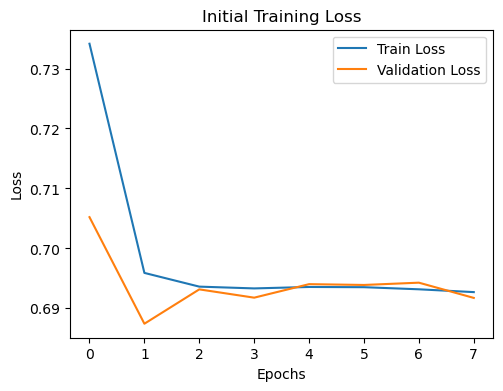

In [15]:
# Plotting the model loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Initial Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

**Question: Was this model successful?** 

**Answer:** No, the ResNet50 model was not successful in achieving the desired performance. Despite completing training, it reached only 40% accuracy, which is well below the target benchmark of 75% for reliable multi-class emotion classification. The final loss was approximately 1.68 (or 168%), indicating that the model's predictions lacked consistency and confidence. The model may not have been fully fine-tuned, freezing too many layers limits the ability to learn emotion-specific features. Emotion recognition requires detecting subtle facial cues, and ResNet50 (originally designed for general object detection) may not be optimized for this type of task out of the box.
* Accuracy: 
* Loss:

## Model #4: ResNet50V2 

### Re-Define Data Generators 

In [16]:
# Re-define parameters 
img_size = (48, 48)
batch_size = 64
num_classes = 2

In [17]:
# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.15,  # Use 15% of training data for validation
    horizontal_flip=True,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Train generator
train_generator = train_datagen.flow_from_directory(
    dataset_train,
    target_size=img_size,
    color_mode='rgb',  # ResNet50V2 expects 3-channel RGB images
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

# Validation generator
val_generator = train_datagen.flow_from_directory(
    dataset_train,
    target_size=img_size,
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)
# Test generator
test_generator = test_datagen.flow_from_directory(
    dataset_test,
    target_size=img_size,
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 10239 images belonging to 2 classes.
Found 1806 images belonging to 2 classes.
Found 3021 images belonging to 2 classes.


### Load ResNet50V2 (saved & pretrained weights)

In [18]:
# Define the model architecture 
base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(48, 48, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(2, activation='softmax')(x)  # 2 emotion classes

model_4 = Model(inputs=base_model.input, outputs=output)

In [19]:
# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False# Freeze the base model layers

# Compile the model
model_4.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
model_4.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 48, 48, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 54, 54, 3) │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 24, 24,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 26, 26,    │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 12, 12,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 12, 12,    │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 12, 12,    │          0 │ conv2_block1_pre… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 12, 12,    │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 12, 12,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 12, 12,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, 14, 14,    │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 12, 12,    │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 12, 12,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 12, 12,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 12, 12,    │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 12, 12,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_out    │ (None, 12, 12,    │          0 │ conv2_block1_0_c

 Total params: 23,827,330 (90.89 MB)

 Trainable params: 262,530 (1.00 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

In [20]:
# Callbacks for training
callbacks_training = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
]

In [21]:
# Train the model (custom head only)
history = model_4.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_steps=val_generator.samples // batch_size,
    callbacks=callbacks_training
)

Epoch 1/20
159/159 ━━━━━━━━━━━━━━━━━━━━ 18s 106ms/step - accuracy: 0.5765 - loss: 1.2834 - val_accuracy: 0.6496 - val_loss: 0.6665 - learning_rate: 1.0000e-04
Epoch 2/20
  1/159 ━━━━━━━━━━━━━━━━━━━━ 15s 98ms/step - accuracy: 0.5156 - loss: 1.0690

/opt/anaconda3/envs/env1/lib/python3.11/site-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


159/159 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.5156 - loss: 1.0690 - val_accuracy: 0.6590 - val_loss: 0.6683 - learning_rate: 1.0000e-04
Epoch 3/20
159/159 ━━━━━━━━━━━━━━━━━━━━ 29s 186ms/step - accuracy: 0.6201 - loss: 0.7803 - val_accuracy: 0.6702 - val_loss: 0.6255 - learning_rate: 1.0000e-04
Epoch 4/20
159/159 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.5625 - loss: 0.6422 - val_accuracy: 0.6708 - val_loss: 0.6320 - learning_rate: 1.0000e-04
Epoch 5/20
159/159 ━━━━━━━━━━━━━━━━━━━━ 18s 113ms/step - accuracy: 0.6412 - loss: 0.6735 - val_accuracy: 0.6724 - val_loss: 0.6127 - learning_rate: 1.0000e-04
Epoch 6/20
159/159 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.7031 - loss: 0.5755 - val_accuracy: 0.6881 - val_loss: 0.5956 - learning_rate: 1.0000e-04
Epoch 7/20
159/159 ━━━━━━━━━━━━━━━━━━━━ 26s 164ms/step - accuracy: 0.6659 - loss: 0.6293 - val_accuracy: 0.6970 - val_loss: 0.5859 - learning_rate: 1.0000e-04
Epoch 8/20
159/159 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy

In [22]:
# Unfreeze some layers for fine-tuning (in base model)
for layer in base_model.layers[-10:]:
    layer.trainable = True

# Recompile the model with a lower learning rate
model_4.compile(optimizer=Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

# Fine-tune the model
history = model_4.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_steps=val_generator.samples // batch_size,
    callbacks=callbacks_training,
)

Epoch 1/20
159/159 ━━━━━━━━━━━━━━━━━━━━ 28s 165ms/step - accuracy: 0.5532 - loss: 0.7600 - val_accuracy: 0.6546 - val_loss: 0.6341 - learning_rate: 1.0000e-05
Epoch 2/20
159/159 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.5938 - loss: 0.7921 - val_accuracy: 0.6507 - val_loss: 0.6382 - learning_rate: 1.0000e-05
Epoch 3/20
159/159 ━━━━━━━━━━━━━━━━━━━━ 67s 420ms/step - accuracy: 0.6093 - loss: 0.6834 - val_accuracy: 0.6501 - val_loss: 0.6437 - learning_rate: 1.0000e-05
Epoch 4/20
159/159 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.6250 - loss: 0.7042 - val_accuracy: 0.6540 - val_loss: 0.6391 - learning_rate: 1.0000e-05
Epoch 5/20
159/159 ━━━━━━━━━━━━━━━━━━━━ 24s 153ms/step - accuracy: 0.6324 - loss: 0.6609 - val_accuracy: 0.6496 - val_loss: 0.6386 - learning_rate: 5.0000e-06
Epoch 6/20
159/159 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.5781 - loss: 0.6138 - val_accuracy: 0.6445 - val_loss: 0.6417 - learning_rate: 5.0000e-06


### Evaluate 

In [23]:
# Evaluate the model on the test set
test_loss, test_accuracy = model_4.evaluate(test_generator, steps=test_generator.samples // batch_size)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 113ms/step - accuracy: 0.7931 - loss: 0.4948
Test Loss: 0.6039, Test Accuracy: 0.6928


In [24]:
# # Save the weights
# model_4.save_weights('ResNet50V2_weights.weights.h5')